# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [13]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [ ]:
help(BinaryClassificationPerformance)

# Function for feature building and extraction on natural language data

In [17]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 5 rows in toxic_data:")
    print(toxic_data.head(5))

    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 18, alternate_sign=False, ngram_range=(1,2), stop_words='english')       
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    # submission condition is test: what's the diff between test and not test here?  
    # 'fitted_transformations.append' vs. '.transform'.  Why in the test condition does transform the data
    # "fit" computes the mean and std to be used for later scaling. (just a computation) 
    # "transform" uses a previously computed mean and std to autoscale the data
        
    if (not test):
        chv = HashingVectorizer(n_features=2 ** 18, alternate_sign=False, analyzer='char_wb', ngram_range=(2,4))
        X_chv = chv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(chv)
        print("Shape of HashingVectorizer char n_gram X:")
        print(X_chv.shape)
    else:
        X_chv = fitted_transformations[1].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer char n_gram X:")
        print(X_chv.shape)
    
#     X_cv = hstack([X_hv, X_chv])
#     print("Shape of Vectorizer combined X:")
#     print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
#     if (not test):
#         transformer = TfidfTransformer()
#         X_tfidf = transformer.fit_transform(X_cv)
#         fitted_transformations.append(transformer)
#     else:
#         X_tfidf = fitted_transformations[1].transform(X_cv)
    
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[2].transform(X_hv)

    #    
    if (not test):
        transformer_chv = TfidfTransformer()
        X_tfidf_chv = transformer_chv.fit_transform(X_chv)
        fitted_transformations.append(transformer_chv)
    else:
        X_tfidf_chv = fitted_transformations[3].transform(X_chv)
    
    # create additional quantitative features

    # what does the form toxic_data['comment_text'] mean?
    toxic_data['char_count'] = toxic_data['comment_text'].str.len()
    toxic_data['Caps_count'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    toxic_data['Caps_ratio'] = pow((toxic_data['Caps_count']+1)/toxic_data['char_count'], 3)
    
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['char_ratio'] = toxic_data['char_count']/toxic_data['word_count']
    
    toxic_data['punc_count_p'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['punc_count_exc'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['punc_count_q'] = toxic_data['comment_text'].str.count("\?")
    
    toxic_data['punc_count'] = toxic_data['punc_count_p'] + toxic_data['punc_count_exc'] + toxic_data['punc_count_q']
    toxic_data['punc_ratio'] = toxic_data['punc_count']/toxic_data['word_count']
    
    toxic_data['Capsword_ratio'] = (toxic_data['Caps_count'] + toxic_data['punc_count'])/toxic_data['word_count']
    
    toxic_data['spaces_count'] = toxic_data['comment_text'].str.count(" ")
    toxic_data['spaces_ratio'] = toxic_data['spaces_count']/toxic_data['char_count']
    toxic_data['spaceswords_ratio'] = toxic_data['spaces_count']/toxic_data['word_count']
    
    # count the number of consecutive caps letters
    toxic_data['consCaps_count'] = toxic_data['comment_text'].str.count(r'[A-Z]{3}')
    toxic_data['consCaps_ratio'] = toxic_data['consCaps_count']/toxic_data['char_count']
    toxic_data['consCapsword_ratio'] = toxic_data['consCaps_count']/toxic_data['word_count']
    
    # current count: 17 quant features
    X_quant_features = toxic_data[["consCapsword_ratio", "consCaps_ratio", "consCaps_count", "spaceswords_ratio", "spaces_ratio", "spaces_count", "char_count", "Caps_count", "Caps_ratio", "word_count", "char_ratio", "punc_count_p", "punc_count_exc", "punc_count_q", "punc_count", "punc_ratio", "Capsword_ratio"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
#     X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_combined = hstack([X_tfidf, X_tfidf_chv, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[4].transform(X_matrix)
        print(X.shape)
    

#     # polynomialregression
#     if (not test):
#         poly = PolynomialFeatures(degree=2, interaction_only=True, order='F')
#         X = poly.fit_transform(X_matrix)
#         fitted_transformations.append(poly)
#         print(X.shape)
#         y = toxic_data['any_toxic']
#     else:
#         X = fitted_transformations[4].transform(X_matrix)
#         print(X.shape)
    
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.05, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [18]:
%%time
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_train.csv', my_random_seed=36)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 5 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0      

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [ ]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("False Positive Rate:")
print(ols_performance_train.performance_measures['FP'] / ols_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_train.performance_measures['TP'] / ols_performance_train.performance_measures['Pos'])

### MODEL: SVM, linear

In [12]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)
print("False Positive Rate:")
print(svm_performance_train.performance_measures['FP'] / svm_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_train.performance_measures['TP'] / svm_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12162, 'TN': 113071, 'FP': 1634, 'FN': 789, 'Accuracy': 0.9810193018737858, 'Precision': 0.8815598724267903, 'Recall': 0.9390780634700023, 'desc': 'svm_train'}
False Positive Rate:
0.014245237783880389
True Positive Rate:
0.9390780634700023


### MODEL: logistic regression

In [49]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)
print("False Positive Rate:")
print(lgs_performance_train.performance_measures['FP'] / lgs_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_train.performance_measures['TP'] / lgs_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 9587, 'TN': 112736, 'FP': 1969, 'FN': 3364, 'Accuracy': 0.958223663595914, 'Precision': 0.8296123226029768, 'Recall': 0.740251718014053, 'desc': 'lgs_train'}
False Positive Rate:
0.017165773070049257
True Positive Rate:
0.740251718014053


In [103]:
%%time
# lgr
from sklearn import linear_model
lgr = linear_model.LogisticRegression(multi_class='multinomial', random_state=1)
lgr.fit(X2_train, y2_train)

lgr_performance_train = BinaryClassificationPerformance(lgr.predict(X2_train), y2_train, 'lgr_train')
lgr_performance_train.compute_measures()

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Wall time: 1min 28s


### MODEL: Naive Bayes

In [104]:
%%time
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=0.01)
nbs.fit(X2_train, y2_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X2_train), y2_train, 'nbs_train')
nbs_performance_train.compute_measures()

Wall time: 878 ms


In [105]:
%%time
# Complement Naive Bayes
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB(alpha=0.00001, norm=True)
cnb.fit(X2_train, y2_train)

cnb_performance_train = BinaryClassificationPerformance(cnb.predict(X2_train), y2_train, 'cnb_train')
cnb_performance_train.compute_measures()

Wall time: 950 ms


### MODEL: Perceptron

In [46]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)
print("False Positive Rate:")
print(prc_performance_train.performance_measures['FP'] / prc_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_train.performance_measures['TP'] / prc_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 8107, 'TN': 113326, 'FP': 1379, 'FN': 4844, 'Accuracy': 0.9512518017171148, 'Precision': 0.8546278726544381, 'Recall': 0.6259748281985947, 'desc': 'prc_train'}
False Positive Rate:
0.012022143760080206
True Positive Rate:
0.6259748281985947


In [37]:
%%time
# multilayer perceptron
# too much runtime
from sklearn import neural_network
mlp = neural_network.MLPClassifier(hidden_layer_sizes=(2, 4))
mlp.fit(X_train, y_train)

mlp_performance_train = BinaryClassificationPerformance(mlp.predict(X_train), y_train, 'mlp_train')
mlp_performance_train.compute_measures()

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Wall time: 2min 2s


### MODEL: Ridge Regression Classifier

In [19]:
%%time
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=25, normalize=True, solver='sag')
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


{'Pos': 15388, 'Neg': 136204, 'TP': 15320, 'TN': 124853, 'FP': 11351, 'FN': 68, 'Accuracy': 0.9246728059528208, 'Precision': 0.5744066589179259, 'Recall': 0.9955809721861191, 'desc': 'rdg'}
Wall time: 1min 27s


In [ ]:
%%time
from sklearn import linear_model
rdg_2p5 = linear_model.RidgeClassifier(alpha=2.5, normalize=True, solver='sag')
rdg_2p5.fit(X_train, y_train)

rdg_performance_train_2p5 = BinaryClassificationPerformance(rdg_2p5.predict(X_train), y_train, 'rdg_2p5')
rdg_performance_train_2p5.compute_measures()
print(rdg_performance_train_2p5.performance_measures)

In [ ]:
%%time
from sklearn import linear_model
rdg_5 = linear_model.RidgeClassifier(alpha=5, normalize=True, solver='sag')
rdg_5.fit(X_train, y_train)

rdg_performance_train_5 = BinaryClassificationPerformance(rdg_5.predict(X_train), y_train, 'rdg_5')
rdg_performance_train_5.compute_measures()

In [33]:
%%time
from sklearn import linear_model
rdg_7p5 = linear_model.RidgeClassifier(alpha=7.5, normalize=True, solver='sag')
rdg_7p5.fit(X_train, y_train)

rdg_performance_train_7p5 = BinaryClassificationPerformance(rdg_7p5.predict(X_train), y_train, 'rdg_7p5')
rdg_performance_train_7p5.compute_measures()

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Wall time: 3min 1s


In [31]:
%%time
from sklearn import linear_model
rdg_10 = linear_model.RidgeClassifier(alpha=10, normalize=True, solver='sag')
rdg_10.fit(X_train, y_train)

rdg_performance_train_10 = BinaryClassificationPerformance(rdg_10.predict(X_train), y_train, 'rdg_10')
rdg_performance_train_10.compute_measures()

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Wall time: 3min 10s


In [23]:
%%time
from sklearn import linear_model
rdg_15 = linear_model.RidgeClassifier(alpha=15, normalize=True, solver='sag')
rdg_15.fit(X_train, y_train)

rdg_performance_train_15 = BinaryClassificationPerformance(rdg_15.predict(X_train), y_train, 'rdg_15')
rdg_performance_train_15.compute_measures()

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Wall time: 3min 11s


In [24]:
%%time
from sklearn import linear_model
rdg_20 = linear_model.RidgeClassifier(alpha=20, normalize=True, solver='sag')
rdg_20.fit(X_train, y_train)

rdg_performance_train_20 = BinaryClassificationPerformance(rdg_20.predict(X_train), y_train, 'rdg_20')
rdg_performance_train_20.compute_measures()

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Wall time: 2min 2s


In [ ]:
%%time
from sklearn import linear_model
rdg_25 = linear_model.RidgeClassifier(alpha=25, normalize=True, solver='sag')
rdg_25.fit(X_train, y_train)

rdg_performance_train_25 = BinaryClassificationPerformance(rdg_25.predict(X_train), y_train, 'rdg_25')
rdg_performance_train_25.compute_measures()
print(rdg_performance_train_25.performance_measures)

In [ ]:
%%time
from sklearn import linear_model
rdg_30 = linear_model.RidgeClassifier(alpha=30, normalize=True, solver='sag')
rdg_30.fit(X_train, y_train)

rdg_performance_train_30 = BinaryClassificationPerformance(rdg_30.predict(X_train), y_train, 'rdg_30')
rdg_performance_train_30.compute_measures()

In [ ]:
%%time
from sklearn import linear_model
rdg_35 = linear_model.RidgeClassifier(alpha=35, normalize=True, solver='sag')
rdg_35.fit(X_train, y_train)

rdg_performance_train_35 = BinaryClassificationPerformance(rdg_35.predict(X_train), y_train, 'rdg_35')
rdg_performance_train_35.compute_measures()

In [ ]:
%%time
from sklearn import linear_model
rdg_40 = linear_model.RidgeClassifier(alpha=40, normalize=True, solver='sag')
rdg_40.fit(X_train, y_train)

rdg_performance_train_40 = BinaryClassificationPerformance(rdg_40.predict(X_train), y_train, 'rdg_40')
rdg_performance_train_40.compute_measures()

### MODEL: Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
# manipulate max_depth
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 0, 'TN': 114705, 'FP': 0, 'FN': 12951, 'Accuracy': 0.8985476593344613, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\Charles\Desktop\ML\A1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

In [ ]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [ ]:
fits = [rdg_performance_train, rdg_performance_train_1, rdg_performance_train_2, rdg_performance_train_7, rdg_performance_train_9, rdg_performance_train_13, rdg_performance_train_19]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0.000415, 0.00043, 0.961, .963])
plt.title('ROC plot Ridge Regression: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [81]:
nbs_predictions = nbs.predict(X_train)

In [ ]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


In [ ]:
# true positives

print("Examples of true positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


In [ ]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 0):
    # model predicts negative
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
        # but training data says should have been positive; thus, false negative
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [70]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)
print("False Positive Rate:")
print(ols_performance_test.performance_measures['FP'] / ols_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_test.performance_measures['TP'] / ols_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 1486, 'TN': 15056, 'FP': 13585, 'FN': 1788, 'Accuracy': 0.518314272285759, 'Precision': 0.09859996018844137, 'Recall': 0.4538790470372633, 'desc': 'ols_test'}
False Positive Rate:
0.4743200307251842
True Positive Rate:
0.4538790470372633


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)
print("False Positive Rate:")
print(svm_performance_test.performance_measures['FP'] / svm_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_test.performance_measures['TP'] / svm_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2486, 'TN': 27403, 'FP': 1238, 'FN': 788, 'Accuracy': 0.9365188782704058, 'Precision': 0.667561761546724, 'Recall': 0.7593158216249236, 'desc': 'svm_test'}
False Positive Rate:
0.043224747739254915
True Positive Rate:
0.7593158216249236


### MODEL: logistic regression

In [ ]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test.performance_measures['FP'] / lgs_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test.performance_measures['TP'] / lgs_performance_test.performance_measures['Pos'])

In [108]:
lgr_performance_test = BinaryClassificationPerformance(lgr.predict(X2_test), y2_test, 'lgr_test')
lgr_performance_test.compute_measures()
print(lgr_performance_test.performance_measures)
print("False Positive Rate:")
print(lgr_performance_test.performance_measures['FP'] / lgr_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(lgr_performance_test.performance_measures['TP'] / lgr_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2355, 'TN': 27952, 'FP': 689, 'FN': 919, 'Accuracy': 0.9496161679461068, 'Precision': 0.7736530880420499, 'Recall': 0.7193036041539401, 'desc': 'lgr_test'}
False Positive Rate:
0.024056422610942357
True Positive Rate:
0.7193036041539401


### MODEL: Naive Bayes

In [109]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X2_test), y2_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)
print("False Positive Rate:")
print(nbs_performance_test.performance_measures['FP'] / nbs_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(nbs_performance_test.performance_measures['TP'] / nbs_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2704, 'TN': 25715, 'FP': 2926, 'FN': 570, 'Accuracy': 0.8904590318032273, 'Precision': 0.4802841918294849, 'Recall': 0.8259010384850336, 'desc': 'nbs_test'}
False Positive Rate:
0.10216123738696274
True Positive Rate:
0.8259010384850336


In [110]:
# Complement NB
cnb_performance_test = BinaryClassificationPerformance(cnb.predict(X2_test), y2_test, 'cnb_test')
cnb_performance_test.compute_measures()
print(cnb_performance_test.performance_measures)
print("True Positive Rate:")
print(cnb_performance_test.performance_measures['TP'] / cnb_performance_test.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(cnb_performance_test.performance_measures['FP'] / cnb_performance_test.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(cnb_performance_test.performance_measures['FN'] / cnb_performance_test.performance_measures['Pos'] * 100)

{'Pos': 3274, 'Neg': 28641, 'TP': 3145, 'TN': 19410, 'FP': 9231, 'FN': 129, 'Accuracy': 0.7067209775967414, 'Precision': 0.2541208791208791, 'Recall': 0.9605986560781918, 'desc': 'cnb_test'}
True Positive Rate:
96.05986560781918
False Positive Rate:
32.230019901539755
False Negative Rate:
3.9401343921808185


### MODEL: Perceptron

In [54]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)
print("False Positive Rate:")
print(prc_performance_test.performance_measures['FP'] / prc_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_test.performance_measures['TP'] / prc_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 1963, 'TN': 28170, 'FP': 471, 'FN': 1311, 'Accuracy': 0.9441641861193796, 'Precision': 0.8064913722267871, 'Recall': 0.5995723885155773, 'desc': 'prc_test'}
False Positive Rate:
0.016444956530847387
True Positive Rate:
0.5995723885155773


### MODEL: Ensemble

In [112]:
%%time
from sklearn.ensemble import VotingClassifier
estimators = [('nbs', nbs), ('cnb', cnb), ('rdg', rdg)]
esb3 = VotingClassifier(estimators, voting='hard')
esb3.fit(X2_train, y2_train)

esb3_performance_train = BinaryClassificationPerformance(esb3.predict(X2_train), y2_train, 'esb3_train')
esb3_performance_train.compute_measures()

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Wall time: 17.5 s


In [113]:
esb3_performance_test = BinaryClassificationPerformance(esb3.predict(X2_test), y2_test, 'esb3_test')
esb3_performance_test.compute_measures()
print(esb3_performance_test.performance_measures)
print("True Positive Rate:")
print(esb3_performance_test.performance_measures['TP'] / esb3_performance_test.performance_measures['Pos'] *100)
print("False Positive Rate:")
print(esb3_performance_test.performance_measures['FP'] / esb3_performance_test.performance_measures['Neg'] *100)

{'Pos': 3274, 'Neg': 28641, 'TP': 2901, 'TN': 25104, 'FP': 3537, 'FN': 373, 'Accuracy': 0.8774870750430832, 'Precision': 0.4506057781919851, 'Recall': 0.8860720830788027, 'desc': 'esb3_test'}
True Positive Rate:
88.60720830788027
False Positive Rate:
12.349429140043993


### MODEL: Ridge Regression Classifier

In [25]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)
print("True Positive Rate:")
print(rdg_performance_test.performance_measures['TP'] / rdg_performance_test.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test.performance_measures['FP'] / rdg_performance_test.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test.performance_measures['FN'] / rdg_performance_test.performance_measures['Pos'] * 100)

{'Pos': 837, 'Neg': 7142, 'TP': 783, 'TN': 6358, 'FP': 784, 'FN': 54, 'Accuracy': 0.894974307557338, 'Precision': 0.49968091895341415, 'Recall': 0.9354838709677419, 'desc': 'rdg_test'}
True Positive Rate:
93.54838709677419
False Positive Rate:
10.977317278073368
False Negative Rate:
6.451612903225806


In [ ]:
rdg_performance_test_2p5 = BinaryClassificationPerformance(rdg_2p5.predict(X_test), y_test, 'rdg_test_2p5')
rdg_performance_test_2p5.compute_measures()
print("True Positive Rate:")
print(rdg_performance_test_2p5.performance_measures['TP'] / rdg_performance_test_2p5.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_2p5.performance_measures['FP'] / rdg_performance_test_2p5.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_2p5.performance_measures['FN'] / rdg_performance_test_2p5.performance_measures['Pos'] * 100)

In [ ]:
rdg_performance_test_5 = BinaryClassificationPerformance(rdg_5.predict(X_test), y_test, 'rdg_test_5')
rdg_performance_test_5.compute_measures()
print("True Positive Rate:")
print(rdg_performance_test_5.performance_measures['TP'] / rdg_performance_test_5.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_5.performance_measures['FP'] / rdg_performance_test_5.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_5.performance_measures['FN'] / rdg_performance_test_5.performance_measures['Pos'] * 100)

In [35]:
rdg_performance_test_7p5 = BinaryClassificationPerformance(rdg_7p5.predict(X_test), y_test, 'rdg_test_7p5')
rdg_performance_test_7p5.compute_measures()
print("True Positive Rate:")
print(rdg_performance_test_7p5.performance_measures['TP'] / rdg_performance_test_7p5.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_7p5.performance_measures['FP'] / rdg_performance_test_7p5.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_7p5.performance_measures['FN'] / rdg_performance_test_7p5.performance_measures['Pos'] * 100)

True Positive Rate:
98.2078853046595
False Positive Rate:
18.16017922150658
False Negative Rate:
1.7921146953405016


In [32]:
rdg_performance_test_10 = BinaryClassificationPerformance(rdg_10.predict(X_test), y_test, 'rdg_test_10')
rdg_performance_test_10.compute_measures()
print("True Positive Rate:")
print(rdg_performance_test_10.performance_measures['TP'] / rdg_performance_test_10.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_10.performance_measures['FP'] / rdg_performance_test_10.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_10.performance_measures['FN'] / rdg_performance_test_10.performance_measures['Pos'] * 100)

True Positive Rate:
97.84946236559139
False Positive Rate:
16.185942313077568
False Negative Rate:
2.1505376344086025


In [26]:
rdg_performance_test_15 = BinaryClassificationPerformance(rdg_15.predict(X_test), y_test, 'rdg_test_15')
rdg_performance_test_15.compute_measures()
print("True Positive Rate:")
print(rdg_performance_test_15.performance_measures['TP'] / rdg_performance_test_15.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_15.performance_measures['FP'] / rdg_performance_test_15.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_15.performance_measures['FN'] / rdg_performance_test_15.performance_measures['Pos'] * 100)

True Positive Rate:
96.1768219832736
False Positive Rate:
13.679641556986837
False Negative Rate:
3.823178016726404


In [28]:
rdg_performance_test_20 = BinaryClassificationPerformance(rdg_20.predict(X_test), y_test, 'rdg_test_20')
rdg_performance_test_20.compute_measures()
print("True Positive Rate:")
print(rdg_performance_test_20.performance_measures['TP'] / rdg_performance_test_20.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_20.performance_measures['FP'] / rdg_performance_test_20.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_20.performance_measures['FN'] / rdg_performance_test_20.performance_measures['Pos'] * 100)

True Positive Rate:
94.98207885304659
False Positive Rate:
12.11145337440493
False Negative Rate:
5.017921146953405


In [28]:
rdg_performance_test_25 = BinaryClassificationPerformance(rdg_25.predict(X_test), y_test, 'rdg_test_25')
rdg_performance_test_25.compute_measures()
print(rdg_performance_test_25.performance_measures)
print("True Positive Rate:")
print(rdg_performance_test_25.performance_measures['TP'] / rdg_performance_test_25.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_25.performance_measures['FP'] / rdg_performance_test_25.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_25.performance_measures['FN'] / rdg_performance_test_25.performance_measures['Pos'] * 100)

{'Pos': 3274, 'Neg': 28641, 'TP': 2910, 'TN': 25960, 'FP': 2681, 'FN': 364, 'Accuracy': 0.9045903180322732, 'Precision': 0.5204793417993203, 'Recall': 0.8888210140500916, 'desc': 'rdg_test_25'}
True Positive Rate:
88.88210140500917
False Positive Rate:
9.36070667923606
False Negative Rate:
11.117898594990837


In [29]:
rdg_performance_test_30 = BinaryClassificationPerformance(rdg_30.predict(X_test), y_test, 'rdg_test_30')
rdg_performance_test_30.compute_measures()
print(rdg_performance_test_30.performance_measures)
print("True Positive Rate:")
print(rdg_performance_test_30.performance_measures['TP'] / rdg_performance_test_30.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_30.performance_measures['FP'] / rdg_performance_test_30.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_30.performance_measures['FN'] / rdg_performance_test_30.performance_measures['Pos'] * 100)

{'Pos': 3274, 'Neg': 28641, 'TP': 2843, 'TN': 26281, 'FP': 2360, 'FN': 431, 'Accuracy': 0.9125489581701395, 'Precision': 0.5464155295022103, 'Recall': 0.8683567501527184, 'desc': 'rdg_test_30'}
True Positive Rate:
86.83567501527185
False Positive Rate:
8.239935756433086
False Negative Rate:
13.164324984728163


In [14]:
rdg_performance_test_35 = BinaryClassificationPerformance(rdg_35.predict(X_test), y_test, 'rdg_test_35')
rdg_performance_test_35.compute_measures()
print(rdg_performance_test_35.performance_measures)
print("True Positive Rate:")
print(rdg_performance_test_35.performance_measures['TP'] / rdg_performance_test_35.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_35.performance_measures['FP'] / rdg_performance_test_35.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_35.performance_measures['FN'] / rdg_performance_test_35.performance_measures['Pos'] * 100)

{'Pos': 3274, 'Neg': 28641, 'TP': 2783, 'TN': 26513, 'FP': 2128, 'FN': 491, 'Accuracy': 0.9179382735390882, 'Precision': 0.5666870291183058, 'Recall': 0.8500305436774588, 'desc': 'rdg_test_35'}
True Positive Rate:
85.00305436774588
False Positive Rate:
7.429908173597291
False Negative Rate:
14.996945632254125


In [15]:
rdg_performance_test_40 = BinaryClassificationPerformance(rdg_40.predict(X_test), y_test, 'rdg_test_40')
rdg_performance_test_40.compute_measures()
print(rdg_performance_test_40.performance_measures)
print("True Positive Rate:")
print(rdg_performance_test_40.performance_measures['TP'] / rdg_performance_test_40.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(rdg_performance_test_40.performance_measures['FP'] / rdg_performance_test_40.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(rdg_performance_test_40.performance_measures['FN'] / rdg_performance_test_40.performance_measures['Pos'] * 100)

{'Pos': 3274, 'Neg': 28641, 'TP': 2731, 'TN': 26729, 'FP': 1912, 'FN': 543, 'Accuracy': 0.9230769230769231, 'Precision': 0.5881972862373466, 'Recall': 0.8341478313989005, 'desc': 'rdg_test_40'}
True Positive Rate:
83.41478313989005
False Positive Rate:
6.675744561991551
False Negative Rate:
16.58521686010996


### MODEL: Random Forest Classifier

In [ ]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

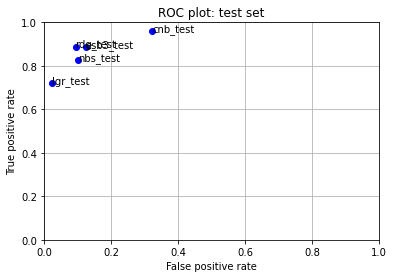

In [114]:
fits = [rdg_performance_test, nbs_performance_test, cnb_performance_test, lgr_performance_test, esb3_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
# fits = [rdg_performance_train, rdg_performance_train_1, rdg_performance_train_2, rdg_performance_train_5, rdg_performance_train_7, rdg_performance_train_9]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'rx')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)    

plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.grid(b=True)
plt.show()

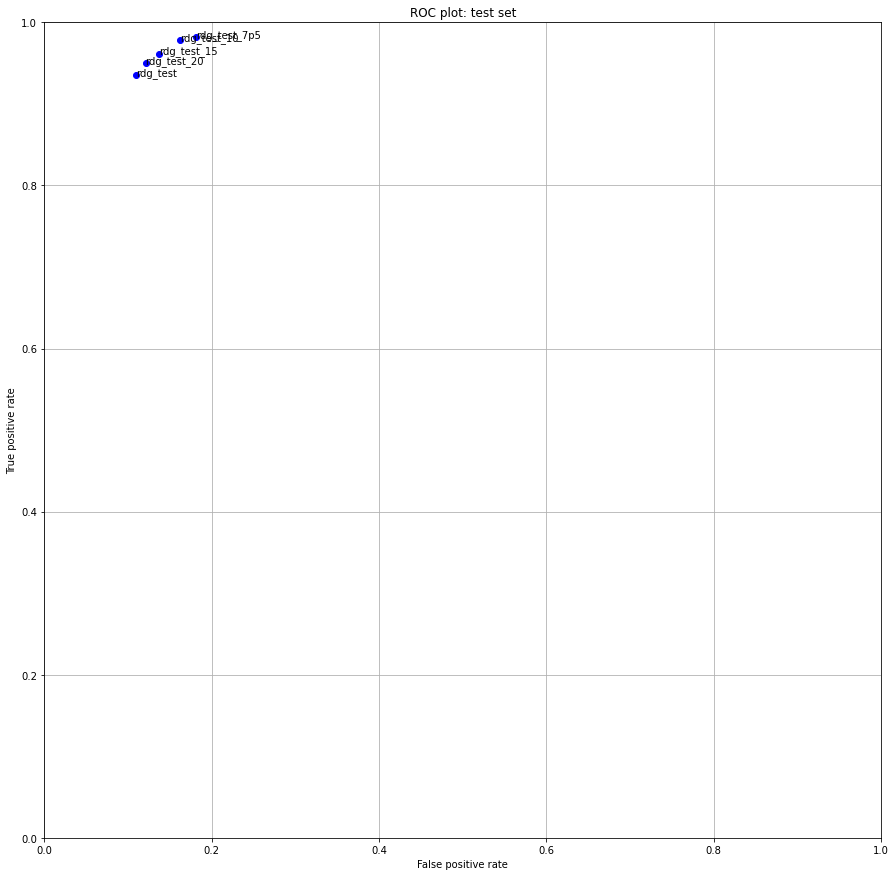

In [37]:
# rdg plot
fits = [rdg_performance_test, rdg_performance_test_7p5, rdg_performance_test_10, rdg_performance_test_15, rdg_performance_test_20]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
# fits = [rdg_performance_train, rdg_performance_train_1, rdg_performance_train_2, rdg_performance_train_5, rdg_performance_train_7, rdg_performance_train_9]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'rx')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)    

plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.grid(b=True)
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [38]:
%%time
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_test.csv', my_random_seed=36, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 5 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 262144)
Shape of HashingVectorizer char n_gram X:
(153164, 262144)
Look at a few rows of the new quantitative features: 
   consCapsword_ratio  consCaps_ratio  consCaps_count  spaceswords_ratio  \
0            0.000000        0.000000               0           0.986111   
1            0.076

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [124]:
# store the id from the raw data
my_submission2 = pd.DataFrame(raw_data2["id"])
# concatenate predictions to the id
my_submission2["esb"] = esb3.predict(X2_test_submission)
# look at the proportion of positive predictions
# print(my_submission['prediction'].mean())

my_submission2["nbs"] = nbs.predict(X2_test_submission)

my_submission2["cnb"] = cnb.predict(X2_test_submission)

my_submission2["lgr"] = lgr.predict(X2_test_submission)

my_submission = pd.DataFrame(raw_data["id"])

my_submission["rdg"] = rdg.predict(X_test_submission)

# print(my_submission["rdg"].head())

In [ ]:
print(my_submission.shape)
print(my_submission2.shape)
m1 = pd.concat([my_submission2, my_submission["rdg"]], axis=1)
# print(m1.head(50))
# ["prediction_esb", "prediction_nbs", "prediction_cnb", "prediction_lgr", "prediction_rdg"]
m1["Ensemble"] = m1["esb"]*0.03 + m1["rdg"]*1.02 + m1["nbs"]*0.99 + m1["cnb"]*0.98 + m1["lgr"]*0.98
m1["ens_int"] = (m1["Ensemble"]>2).astype(int)
# print(Ensemble.head(50))
# print(m1["ens_int"].head(50))
m1["prediction_ens"] = m1["ens_int"].replace({0: "False", 1: "True"})
# print(ens.head(50))
my_final = pd.concat([m1["id"], m1["prediction_ens"]], axis=1)
print(my_final.head(10))
# my_final = my_final.rename(columns={0: "prediction_ens"}, inplace=True

In [ ]:
my_final.head(10)
# my_submission.to_csv('/Users/Charles/Desktop/ML/A1/toxiccomments_ensemble.csv', index=False)

In [ ]:
my_final.shape

In [134]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_final.to_csv('/Users/Charles/Desktop/ML/A1/toxiccomments_5th_submission.csv', index=False)

---

# <span style="color:red">SUBMISSION</span>

---

In [39]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg_10.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.39923872450445275


In [40]:
raw_data.head()

,id,comment_text,char_count,Caps_count,Caps_ratio,word_count,char_ratio,punc_count_p,punc_count_exc,punc_count_q,punc_count,punc_ratio,Capsword_ratio,spaces_count,spaces_ratio,spaceswords_ratio,consCaps_count,consCaps_ratio,consCapsword_ratio
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367,4,0.000003,72,5.097222,10,0,0,10,0.138889,0.194444,71,0.193460,0.986111,0,0.00,0.000000
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50,7,0.004096,13,3.846154,1,0,0,1,0.076923,0.615385,12,0.240000,0.923077,1,0.02,0.076923
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,4,0.000794,16,3.375000,0,0,0,0,0.000000,0.250000,15,0.277778,0.937500,0,0.00,0.000000
3,00017563c3f7919a,":If you have a look back at the source, the in...",205,4,0.000015,38,5.394737,3,0,0,3,0.078947,0.184211,37,0.180488,0.973684,0,0.00,0.000000
4,00017695ad8997eb,I don't anonymously edit articles at all.,41,1,0.000116,7,5.857143,1,0,0,1,0.142857,0.285714,6,0.146341,0.857143,0,0.00,0.000000


In [41]:
my_submission.head(10)

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,True
3,00017563c3f7919a,False
4,00017695ad8997eb,False
5,0001ea8717f6de06,False
6,00024115d4cbde0f,False
7,000247e83dcc1211,True
8,00025358d4737918,False
9,00026d1092fe71cc,False


In [42]:
my_submission.shape

(153164, 2)

In [43]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/Charles/Desktop/ML/A1/toxiccomments_finalsubmission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation